In [1]:
import os
import sys
import torch
from torchsummary import summary
import random

sys.path.append('../../shared_libraries')
sys.path.append('../../02_training/siamese_networks')
from trainer import Trainer
from config import get_config
from utils import prepare_dirs, save_config, load_config
from data_loader import get_train_valid_loader, get_test_loader

root_dir = os.getcwd()

# Load configuration

In [3]:
config, unparsed = get_config()


config.num_model = 4
config.batch_size = 64
config.is_train = False
config.use_gpu = False
config.use_batch_norm = True
config.data_dir = '../../01_data_preparation/omniglot/data/changed'
config.ckpt_dir = '../../02_training/siamese_networks/ckpt/'
config.logs_dir = '../../02_training/siamese_networks/logs/'

# ensure directories are setup
prepare_dirs(config)

config.print_values()

valid_trials : 320
test_trials : 400
way : 20
num_train : 90000
batch_size : 64
num_workers : 1
shuffle : True
augment : True
is_train : False
get_embedding : False
n_embeddings : 1000
alphabet : Mongolian
epochs : 200
init_momentum : 0.5
lr_patience : 1
train_patience : 20
use_batch_norm : True
flush : False
num_model : 4
use_gpu : False
best : True
random_seed : 1
data_dir : ../../01_data_preparation/omniglot/data/changed
ckpt_dir : ../../02_training/siamese_networks/ckpt/
logs_dir : ../../02_training/siamese_networks/logs/
resume : False


# Configure testing

In [4]:
# create Omniglot data loaders
torch.manual_seed(config.random_seed)
kwargs = {}
if config.use_gpu:
    torch.cuda.manual_seed(config.random_seed)
    kwargs = {'num_workers': 1, 'pin_memory': True}
if config.is_train:
    data_loader = get_train_valid_loader(
        config.data_dir, config.batch_size,
        config.num_train, config.augment,
        config.way, config.valid_trials,
        config.shuffle, config.random_seed,
        **kwargs
    )
else:
    data_loader = get_test_loader(
        config.data_dir, config.way,
        config.test_trials, config.random_seed,
        **kwargs
    )

# sample 3 layer wise hyperparams if first time training
if config.is_train and not config.resume:
    print("[*] Sampling layer hyperparameters.")

    layer_hyperparams = {
        'layer_init_lrs': [],
        'layer_end_momentums': [],
        'layer_l2_regs': []
    }
    for i in range(6):
        # sample
        lr = random.uniform(1e-4, 1e-1)
        mom = random.uniform(0, 1)
        reg = random.uniform(0, 0.1)

        # store
        layer_hyperparams['layer_init_lrs'].append(lr)
        layer_hyperparams['layer_end_momentums'].append(mom)
        layer_hyperparams['layer_l2_regs'].append(reg)
    try:
        save_config(config, layer_hyperparams, override=True)
    except ValueError:
        print(
            "[!] Samples already exist. Either change the model number,",
            "or delete the json file and rerun.",
            sep=' '
        )
        raise
# else load it from config file
else:
    try:
        layer_hyperparams = load_config(config)
    except FileNotFoundError:
        print("[!] No previously saved config. Set resume to False.")
        raise

[*] Loaded layer hyperparameters.


# Test

In [5]:
trainer = Trainer(config, data_loader, layer_hyperparams)

trainer.test()

../../02_training/siamese_networks\model.py:155: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight, 0, 1e-2)
../../02_training/siamese_networks\model.py:156: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.bias, 0.5, 1e-2)
../../02_training/siamese_networks\model.py:158: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.weight, 0, 2e-1)
../../02_training/siamese_networks\model.py:159: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(m.bias, 0, 1e-2)


[*] Number of model parameters: 1,256,945
[*] Loading model from ../../02_training/siamese_networks/ckpt/exp_4
[*] Loaded best_model_ckpt.tar checkpoint @ epoch 51 with best valid acc of 89.062


../../02_training/siamese_networks\trainer.py:290: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  x1, x2 = Variable(x1, volatile=True), Variable(x2, volatile=True)
C:\Users\bruno.silva\AppData\Local\Continuum\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[*] Test Acc: 342/400 (85.50%)


# Model summary

The output below computes the number of parameters of some layers twice.

The actual size is:
    2,512,801 - 1,616 - 25,120 - 16,416 - 32,832 - 1,180,160 = 1,256,657

In [5]:
summary(trainer.model, input_size=[(1, 105, 105), (1, 105, 105)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 96, 96]           1,616
       BatchNorm2d-2           [-1, 16, 96, 96]              32
            Conv2d-3           [-1, 32, 42, 42]          25,120
       BatchNorm2d-4           [-1, 32, 42, 42]              64
            Conv2d-5           [-1, 32, 18, 18]          16,416
       BatchNorm2d-6           [-1, 32, 18, 18]              64
            Conv2d-7             [-1, 64, 6, 6]          32,832
       BatchNorm2d-8             [-1, 64, 6, 6]             128
            Linear-9                  [-1, 512]       1,180,160
           Conv2d-10           [-1, 16, 96, 96]           1,616
      BatchNorm2d-11           [-1, 16, 96, 96]              32
           Conv2d-12           [-1, 32, 42, 42]          25,120
      BatchNorm2d-13           [-1, 32, 42, 42]              64
           Conv2d-14           [-1, 32,

True summmary:
<pre>
----------------------------------------------------------------<br>
        Layer (type)               Output Shape         Param #<br>
================================================================<br>
            Conv2d-1           [-1, 16, 96, 96]           1,616<br>
            BatchNorm2d-2      [-1, 16, 96, 96]              32<br>
            Conv2d-3           [-1, 32, 42, 42]          25,120<br>
            BatchNorm2d-4      [-1, 32, 42, 42]              64<br>
            Conv2d-5           [-1, 32, 18, 18]          16,416<br>
            BatchNorm2d6       [-1, 32, 42, 42]              64<br>
            Conv2d-7             [-1, 64, 6, 6]          32,832<br>
            BatchNorm2d-8        [-1, 64, 6, 6]             128<br>
            Linear-9                  [-1, 512]       1,180,160<br>
            Linear-10                   [-1, 1]             513<br>
================================================================<br>
Total params: 1,256,945<br>
Trainable params: 1,256,945<br>
Non-trainable params: 0<br>
----------------------------------------------------------------<br>
</pre>

# Plot loss

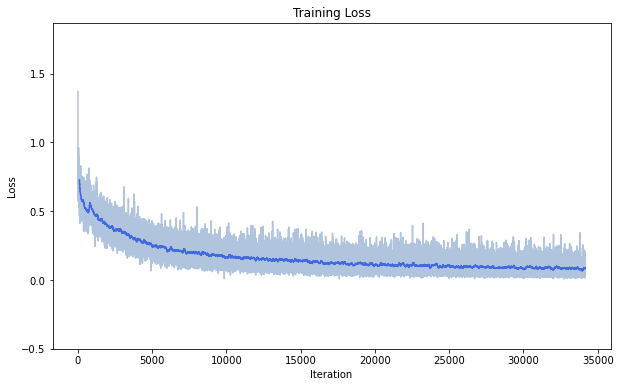

In [6]:
from plotting import plot_train_loss

plot_train_loss(config, 100)